In [796]:
#by Willkie
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from datetime import datetime
from matplotlib import rc
import seaborn as sns
import pandas as pd
warnings.filterwarnings('ignore')
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
#https://discord.com/channels/1134059900666916935/1283610000484208670

In [797]:
# Job dictionary and spec ranges
job_dict = {
    "허": "허밋", "시프": "시프", "썬": "썬콜", "불독": "불독",
    "프": "프리스트", "레": "레인저", "저": "저격수",
    "용": "용기사", "크": "크루세이더", "나": "나이트"
}
job_spec_ranges = {
    "용": (3000, 9000), "크": (2000, 9000), "나": (2000, 9000),
    "허": (1500, 4000), "시프": (1500, 5000), "썬": (500, 1200),
    "불독": (500, 1200), "프": (500, 1200), "레": (2000, 9000),
    "저": (2000, 9000)
}
level_min, level_max = 80, 200

# Regex patterns
time_pattern = r"(오전|오후) \d{1,2}:\d{2}"
job_pattern = r"(\d{2,3})\s?(" + "|".join(job_dict.keys()) + r")"
spec_pattern = r"(\d{3,4})"
map_pattern = r"(망용둥|위용둥|와협|블와둥|협동|레와둥|붉켄|검켄|푸켄|불어전|물어전|오징어|망둥어|듀파|갈림길|골짜기)"

In [798]:
def extract_level_and_spec(text, job_start, job_end, level_range, spec_range):
    """
    Extracts level and spec values by searching limited characters around the job.
    Level is searched from the left, and spec is searched from the right.
    """
    # Limit the search space
    left_text = text[job_start-5 : job_start+5]  # 6 characters left of the job
    right_text = text[job_end+1 : job_end + 10]  # 6 characters right of the job

    # print ("left:", left_text, "right:", right_text)
    
    level, spec = None, None

    # Search for level in the left_text
    for match in re.finditer(r"\d{2,3}", left_text[::-1]):  # Reverse for easier parsing
        num = int(match.group()[::-1])  # Reverse back the number
        if level_range[0] <= num <= level_range[1]:
            level = num
            break

    # Search for spec in the right_text
    for match in re.finditer(r"\d{3,4}", right_text):
        num = int(match.group())
        if spec_range[0] <= num <= spec_range[1]:
            spec = num
            break

    return level, spec

In [799]:
def collect_initial_data(file_path):
    columns = ["party_id", "time", "level", "job", "spec", "map", "date", "valid", "valid_spec"]
    df = pd.DataFrame(columns=columns)

    # Extract date from filename
    month = file_path[-8:-6]
    day = file_path[-6:-4]
    date_from_file = f"2024-{month}-{day}"
    
    party_id = 1
    
    with open(file_path, "r", encoding="utf-8") as file:
        data = file.read()

    blocks = data.split("오늘")
    for block in blocks[1:]:
        time_match = re.search(time_pattern, block)
        time = time_match.group(0) if time_match else None
        map_match = re.search(map_pattern, block)
        map_name = map_match.group(0) if map_match else None

        job_matches = list(re.finditer(job_pattern, block))
        for job_match in job_matches:
            job_short = job_match.group(2)
            job_full = job_dict.get(job_short, "Unknown")

            level, spec = extract_level_and_spec(
                block, job_match.start(), job_match.end(),
                (level_min, level_max), job_spec_ranges.get(job_short, (None, None))
            )
            
            valid = map_name is not None and job_full != "Unknown"

            # print(level, job_full, spec)
            
            # Append new row to DataFrame
            df = pd.concat([
                df,
                pd.DataFrame([{
                    "party_id": party_id,
                    "time": time,
                    "level": level,
                    "job": job_full,
                    "spec": spec,
                    "map": map_name,
                    "date": date_from_file,
                    "valid": valid,
                    "valid_spec": None
                }])
            ], ignore_index=True)

        party_id += 1

    # Remove duplicates
    df = df.drop_duplicates(subset=["map", "level", "job", "spec"], keep="first")

    # Add spec_by_level column
    df["spec_by_level"] = df.apply(
        lambda row: row["spec"] / row["level"] if pd.notna(row["spec"]) and pd.notna(row["level"]) else None,
        axis=1
    )
    # Calculate average spec_by_level by job
    avg_spec_by_level = df.groupby("job")["spec_by_level"].mean().rename("avg_spec_by_level")
    df = df.merge(avg_spec_by_level, on="job", how="left")
    
    # Determine spec_valid based on 20% margin
    def is_spec_valid(row):
        if pd.notna(row["spec_by_level"]) and pd.notna(row["avg_spec_by_level"]):
            lower_bound = 0.8 * row["avg_spec_by_level"]
            upper_bound = 1.2 * row["avg_spec_by_level"]
            return lower_bound <= row["spec_by_level"] <= upper_bound
        return False
    
    df["valid_spec"] = df.apply(is_spec_valid, axis=1)
    
    output_file = file_path.replace('.txt', '.csv')
    df.to_csv(output_file, index=False)
    print(f"Data saved as {output_file}")
    return df

def process_data(df, file_path):
    """
    Filters and processes data to save only rows where valid and valid_spec are True.
    """
    # Filter rows where both 'valid' and 'valid_spec' are True
    processed_df = df[(df["valid"]) & (df["valid_spec"])]

    # Save the processed DataFrame to a CSV file
    processed_output_file = file_path.replace('.txt', '_processed.csv')
    processed_df.to_csv(processed_output_file, index=False)

    print(f"Processed valid data saved as {processed_output_file}")
    return processed_df

def process_files(file_paths):
    """
    Processes multiple text files, combines them into a single DataFrame for valid processed data,
    and saves the final output as a CSV file.
    """
    all_raw_data = []
    all_valid_processed_data = []

    for file_path in file_paths:
        # Collect initial raw data
        raw_df = collect_initial_data(file_path)
        
        # Process and filter valid data
        valid_processed_df = process_data(raw_df, file_path)
        
        all_raw_data.append(raw_df)
        all_valid_processed_data.append(valid_processed_df)

    # Combine all raw DataFrames
    combined_raw_data = pd.concat(all_raw_data, ignore_index=True)
    combined_valid_processed_data = pd.concat(all_valid_processed_data, ignore_index=True)

    # Save the combined DataFrames
    combined_raw_data.to_csv("df.csv", index=False)
    combined_valid_processed_data.to_csv("processed_df.csv", index=False)

    print("Combined raw and valid processed data saved as 'combined_raw_data.csv' and 'combined_valid_processed_data.csv'.")
    return combined_raw_data, combined_valid_processed_data

In [800]:
# List of file paths
# "1207.txt", "1208.txt", "1209.txt", "1210.txt", #리프
file_paths = ["1211.txt", "1212.txt", "1213.txt", "1214.txt", "1215.txt", "1216.txt"]

# Process files and save results
df_combined_raw, df_combined_valid_processed = process_files(file_paths)

Data saved as 1211.csv
Processed valid data saved as 1211_processed.csv
Data saved as 1212.csv
Processed valid data saved as 1212_processed.csv
Data saved as 1213.csv
Processed valid data saved as 1213_processed.csv
Data saved as 1214.csv
Processed valid data saved as 1214_processed.csv
Data saved as 1215.csv
Processed valid data saved as 1215_processed.csv
Data saved as 1216.csv
Processed valid data saved as 1216_processed.csv
Combined raw and valid processed data saved as 'combined_raw_data.csv' and 'combined_valid_processed_data.csv'.


In [801]:
df = pd.read_csv("df.csv")
df

,party_id,time,level,job,spec,map,date,valid,valid_spec,spec_by_level,avg_spec_by_level
0,1,오후 1:11,96.0,허밋,NaN,NaN,2024-12-11,False,False,NaN,18.677387
1,2,오후 1:12,141.0,크루세이더,NaN,골짜기,2024-12-11,True,False,NaN,32.361493
2,2,오후 1:12,151.0,용기사,NaN,골짜기,2024-12-11,True,False,NaN,35.816408
3,2,오후 1:12,103.0,허밋,NaN,골짜기,2024-12-11,True,False,NaN,18.677387
4,2,오후 1:12,131.0,레인저,NaN,골짜기,2024-12-11,True,False,NaN,21.206268
...,...,...,...,...,...,...,...,...,...,...,...
1733,425,오전 1:10,85.0,크루세이더,NaN,듀파,2024-12-16,True,False,NaN,31.653497
1734,425,오전 1:10,83.0,프리스트,NaN,듀파,2024-12-16,True,False,NaN,6.232592
1735,426,오전 1:11,132.0,용기사,4440.0,NaN,2024-12-16,False,True,33.636364,35.216337
1736,428,오전 1:11,119.0,레인저,2590.0,망용둥,2024-12-16,True,True,21.764706,22.352318


In [802]:
processed_df = pd.read_csv("processed_df.csv")
processed_df

,party_id,time,level,job,spec,map,date,valid,valid_spec,spec_by_level,avg_spec_by_level
0,6,오후 1:12,120,허밋,2100,망용둥,2024-12-11,True,True,17.500000,18.677387
1,6,오후 1:12,127,썬콜,760,망용둥,2024-12-11,True,True,5.984252,6.213098
2,6,오후 1:12,116,허밋,2000,망용둥,2024-12-11,True,True,17.241379,18.677387
3,16,오후 1:12,135,허밋,2620,망용둥,2024-12-11,True,True,19.407407,18.677387
4,17,오후 1:12,145,허밋,2800,망용둥,2024-12-11,True,True,19.310345,18.677387
...,...,...,...,...,...,...,...,...,...,...,...
179,423,오전 1:10,148,용기사,5250,협동,2024-12-16,True,True,35.472973,35.216337
180,423,오전 1:10,124,허밋,2100,협동,2024-12-16,True,True,16.935484,18.232255
181,423,오전 1:10,133,용기사,4800,협동,2024-12-16,True,True,36.090226,35.216337
182,423,오전 1:10,149,썬콜,920,협동,2024-12-16,True,True,6.174497,6.240047


In [803]:
hermit = processed_df[(processed_df['job'] == '허밋')]
hermit

,party_id,time,level,job,spec,map,date,valid,valid_spec,spec_by_level,avg_spec_by_level
0,6,오후 1:12,120,허밋,2100,망용둥,2024-12-11,True,True,17.500000,18.677387
2,6,오후 1:12,116,허밋,2000,망용둥,2024-12-11,True,True,17.241379,18.677387
3,16,오후 1:12,135,허밋,2620,망용둥,2024-12-11,True,True,19.407407,18.677387
4,17,오후 1:12,145,허밋,2800,망용둥,2024-12-11,True,True,19.310345,18.677387
6,24,오후 1:13,164,허밋,3200,협동,2024-12-11,True,True,19.512195,18.677387
14,98,오후 1:16,140,허밋,2500,불어전,2024-12-11,True,True,17.857143,18.677387
18,151,오후 1:34,146,허밋,2700,망용둥,2024-12-11,True,True,18.493151,18.677387
19,169,오후 1:34,164,허밋,3250,협동,2024-12-11,True,True,19.817073,18.677387
23,289,오후 1:37,111,허밋,2100,갈림길,2024-12-11,True,True,18.918919,18.677387
26,505,오후 2:02,93,허밋,1672,듀파,2024-12-11,True,True,17.978495,18.677387


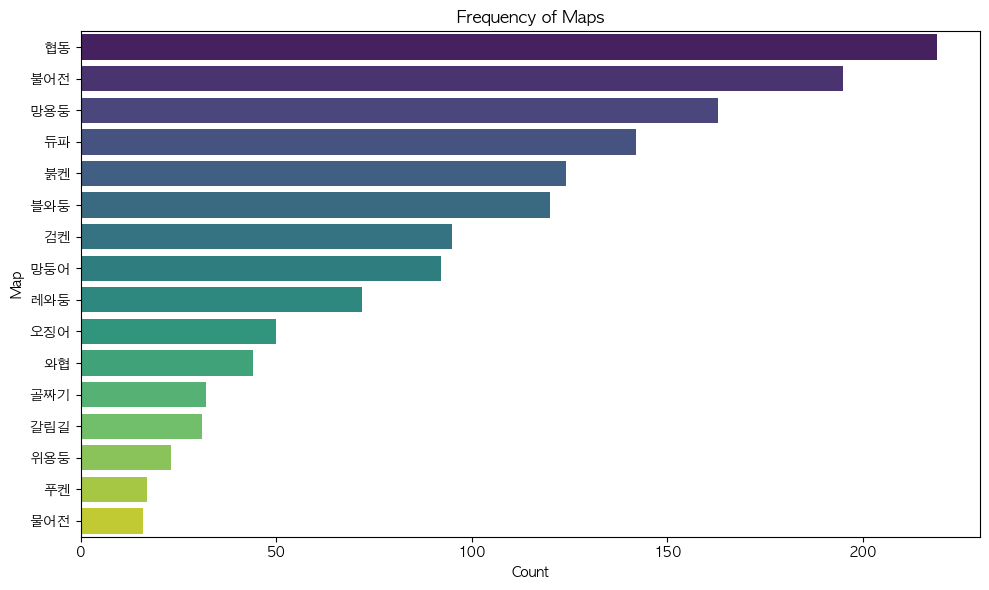

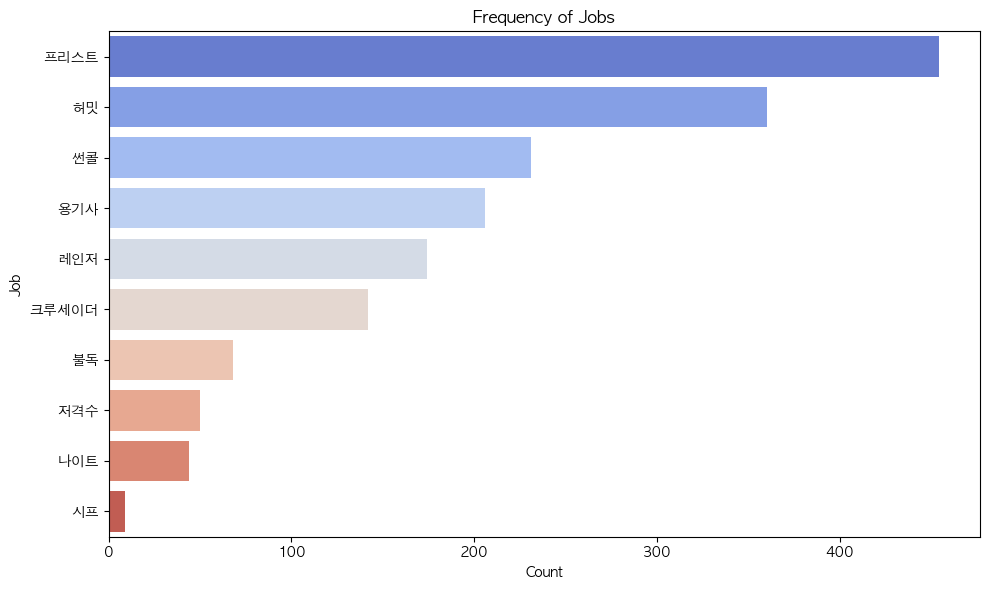

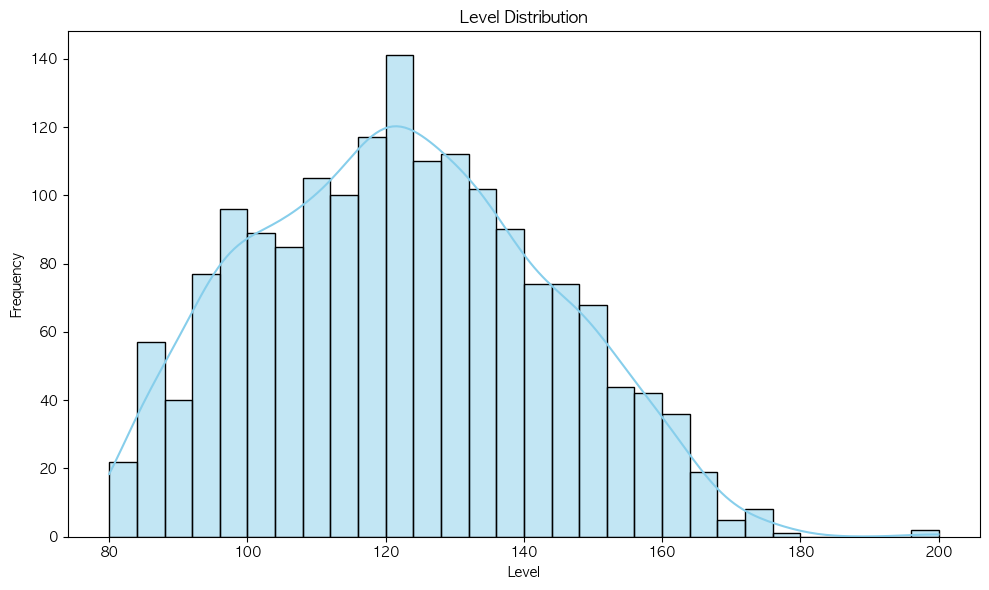

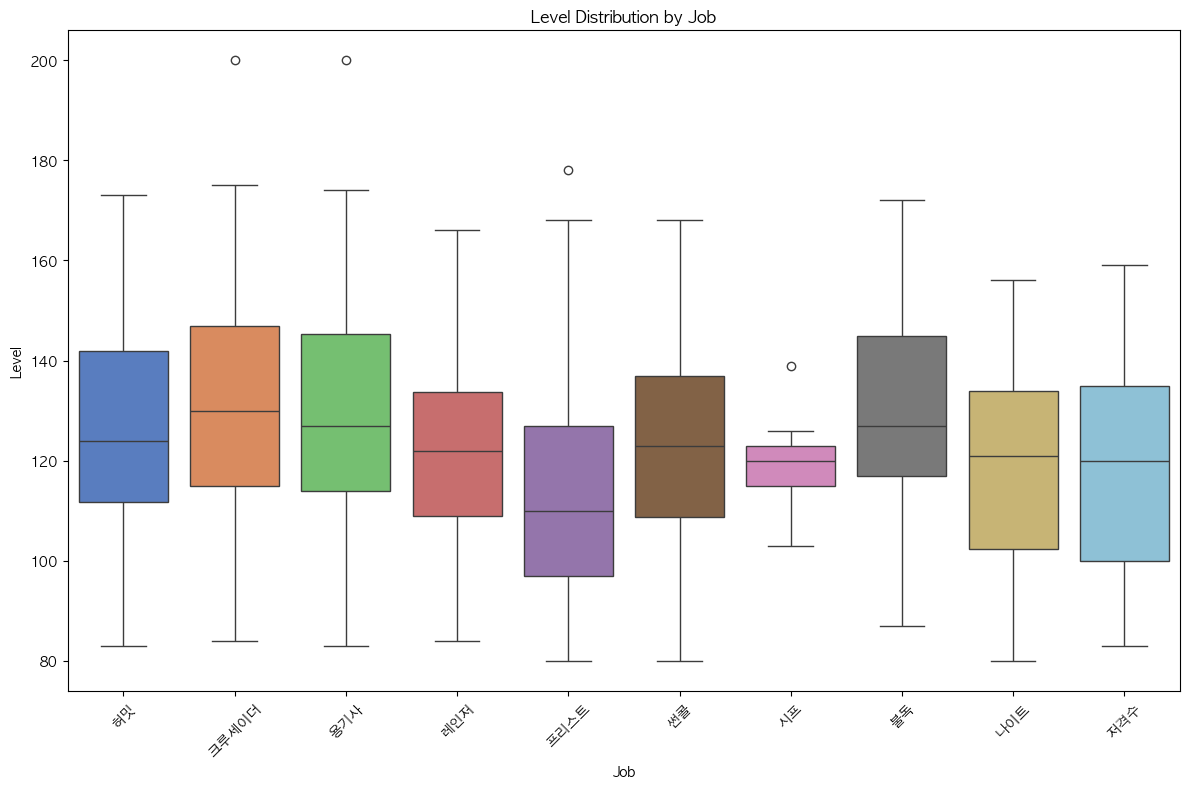

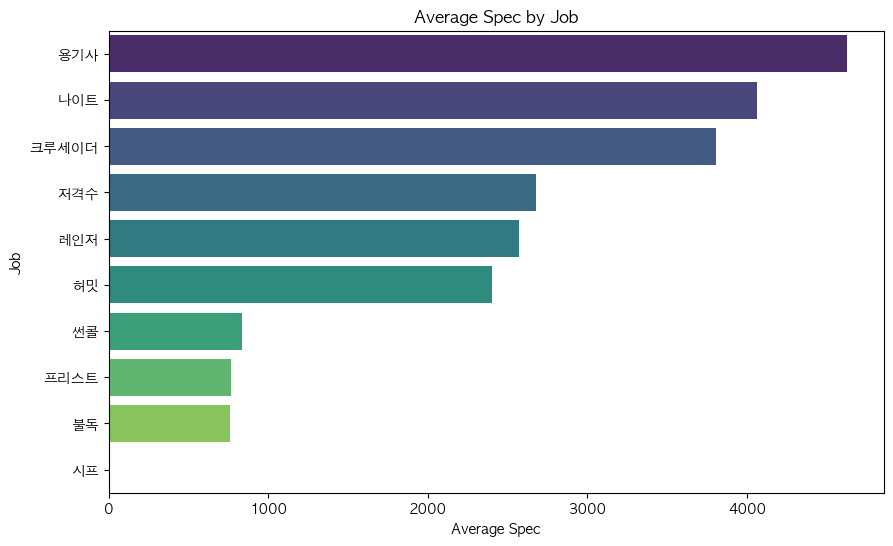

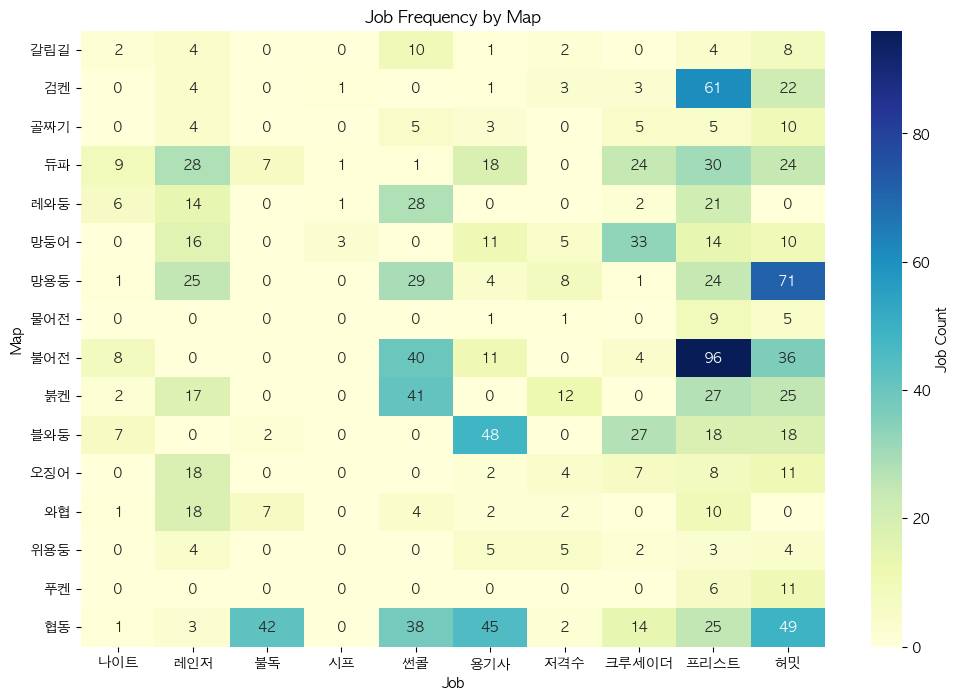

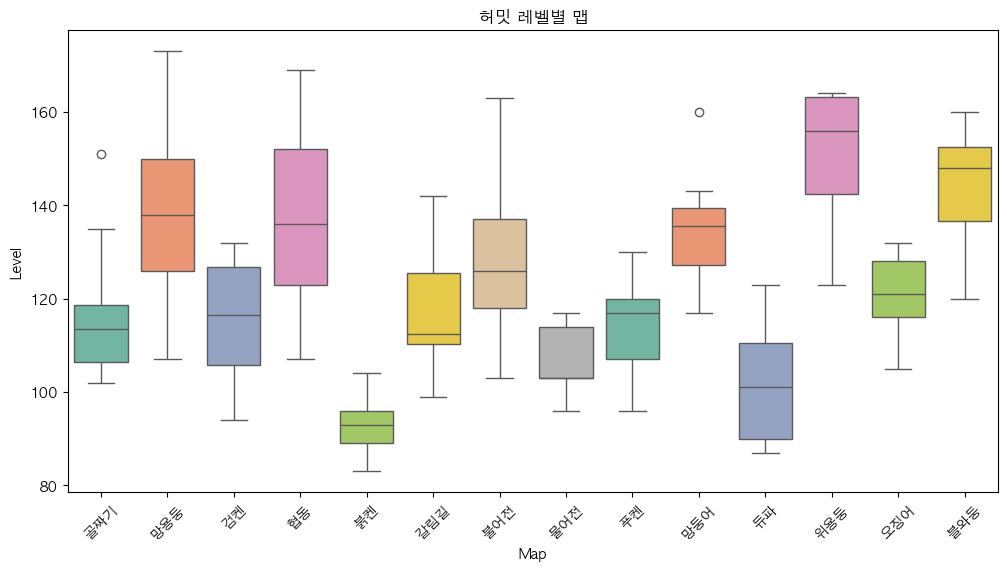

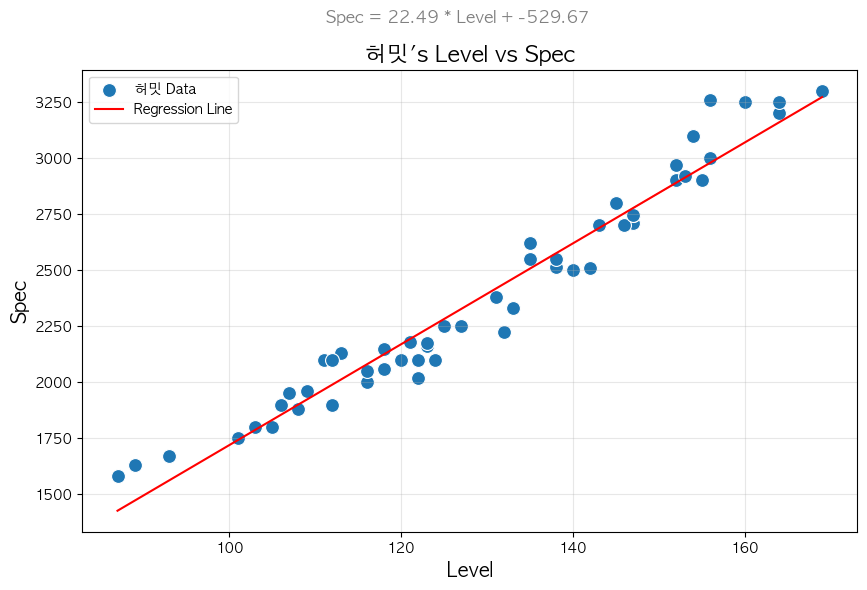

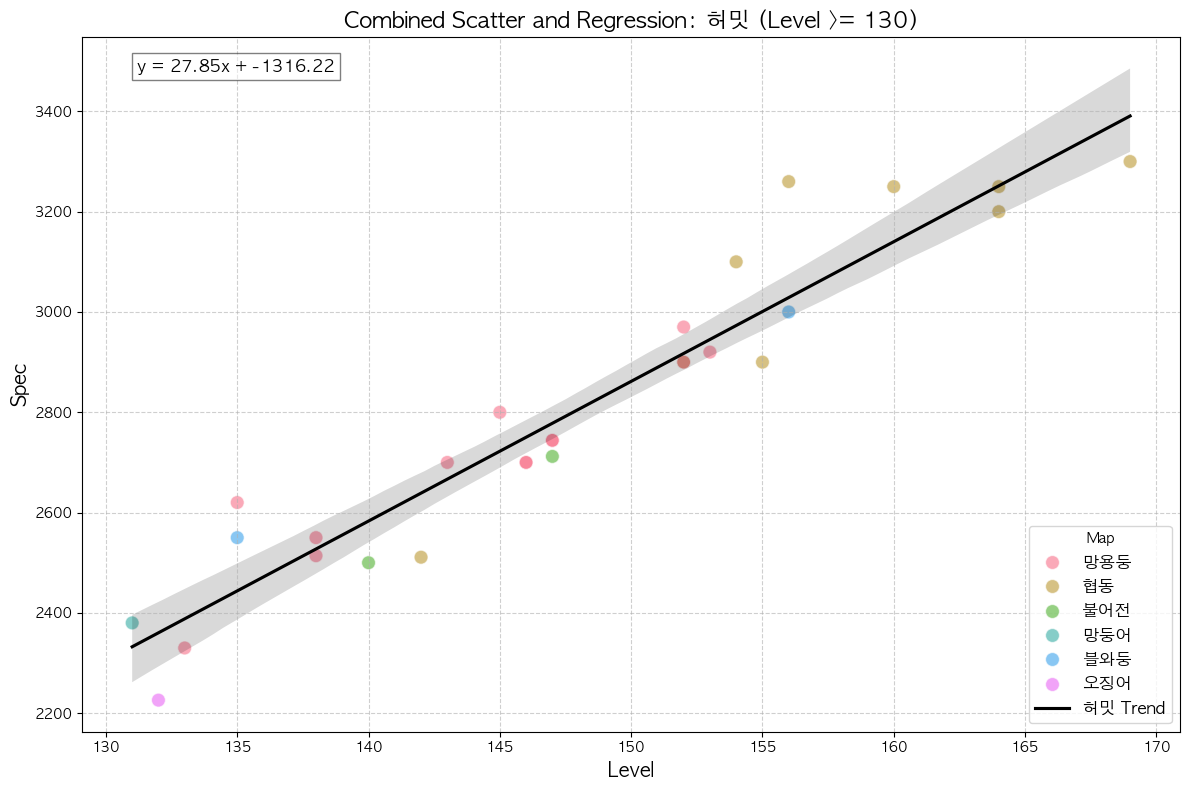

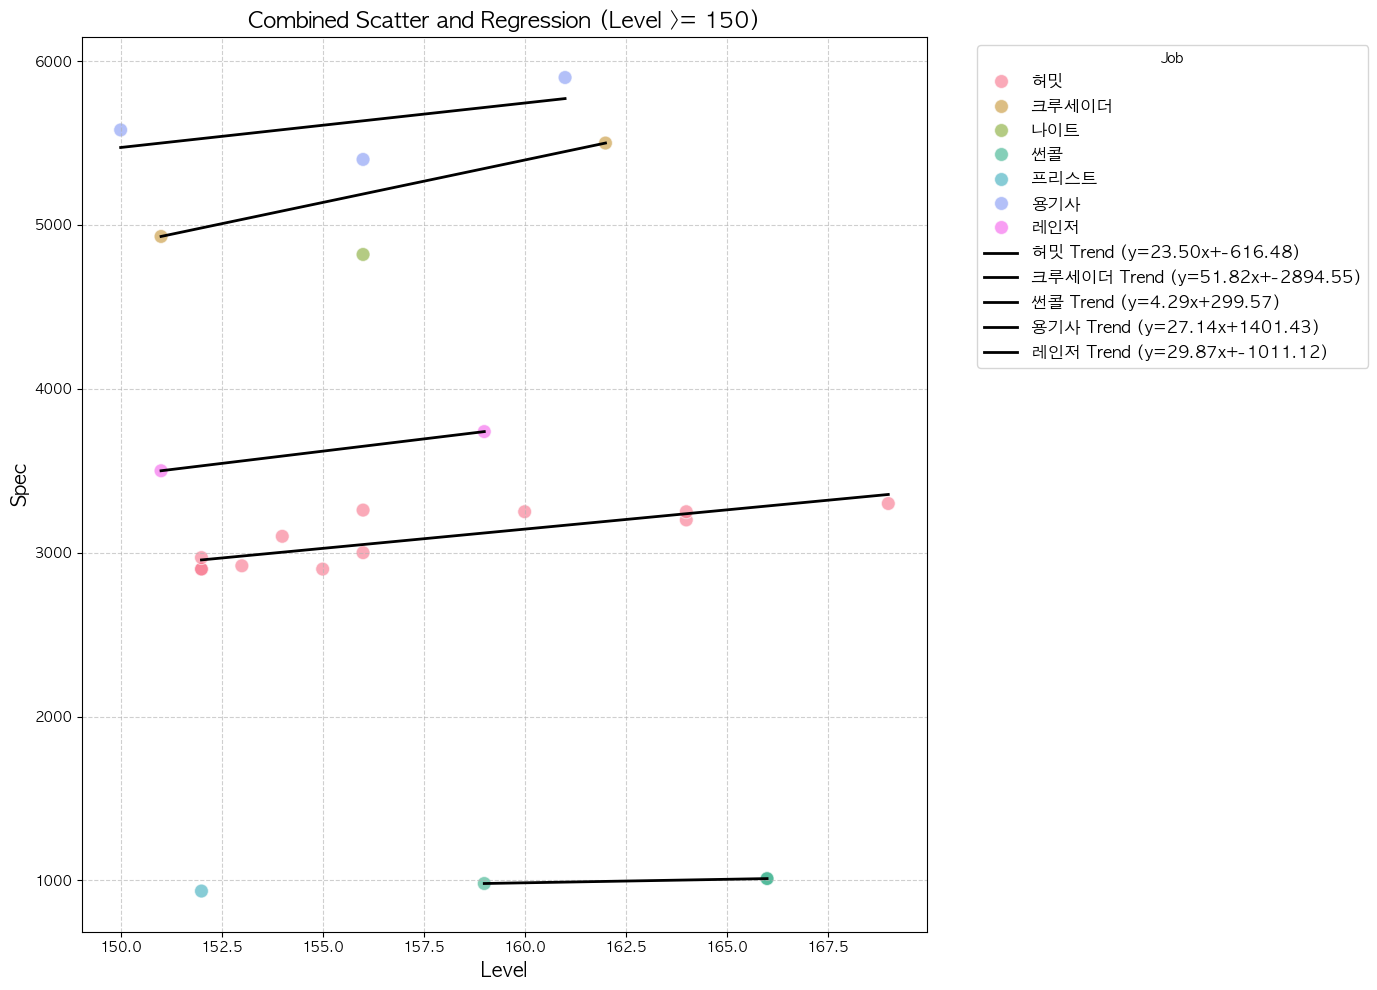

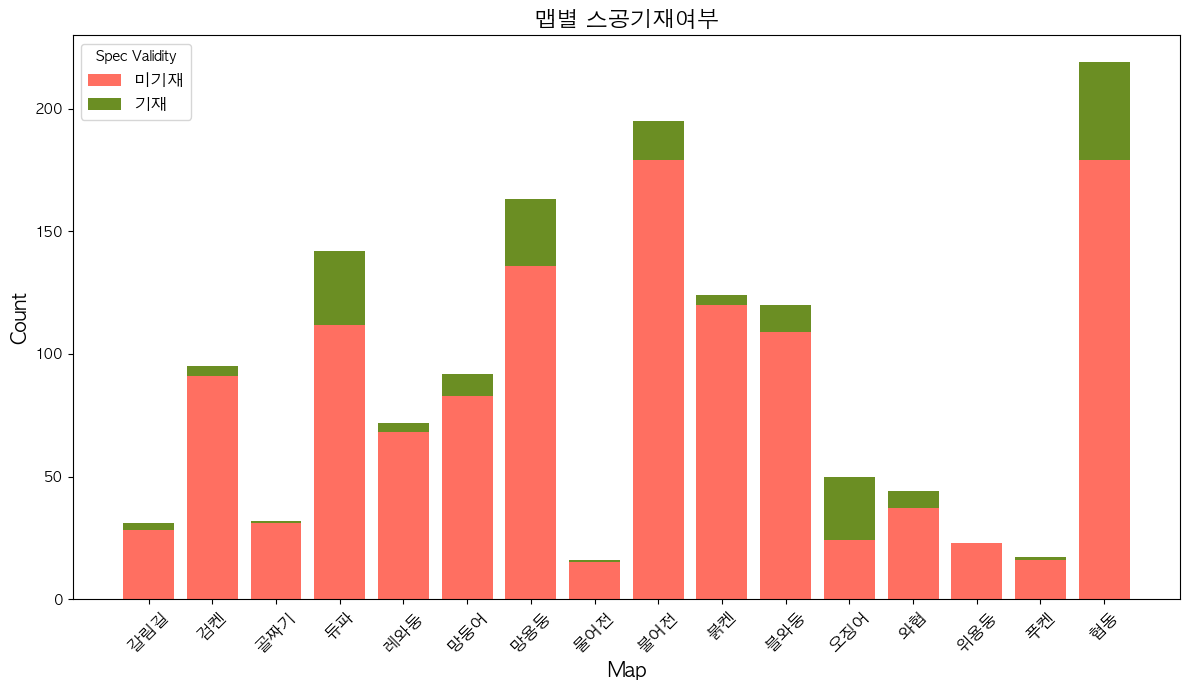

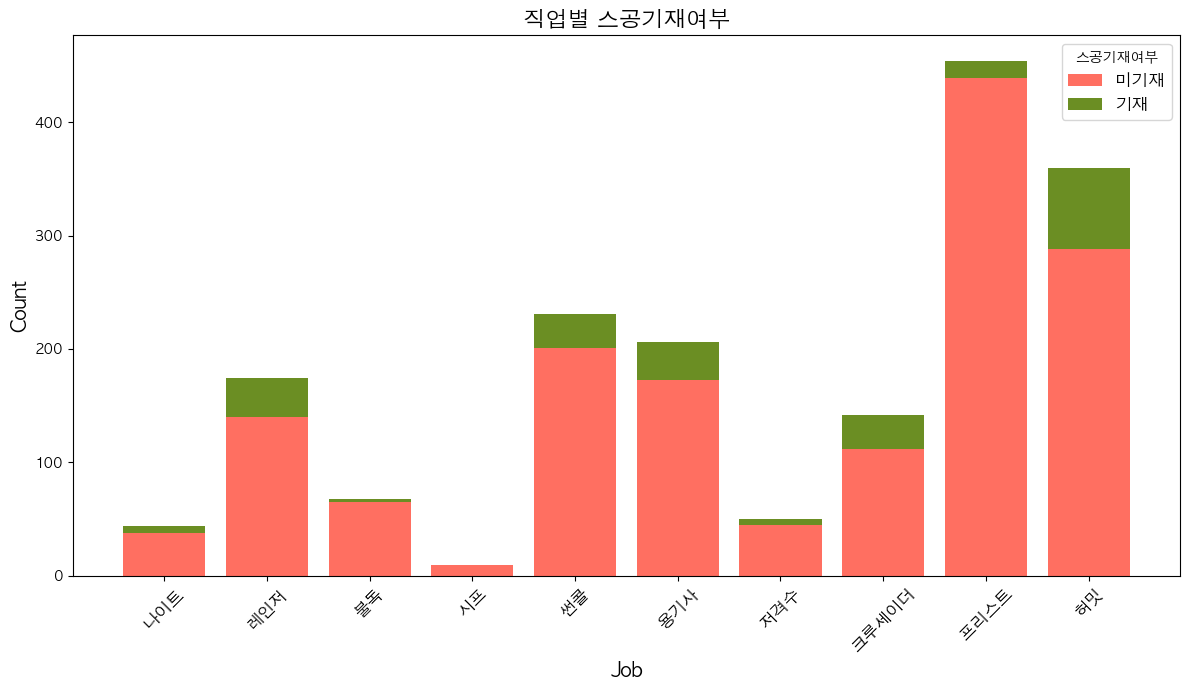

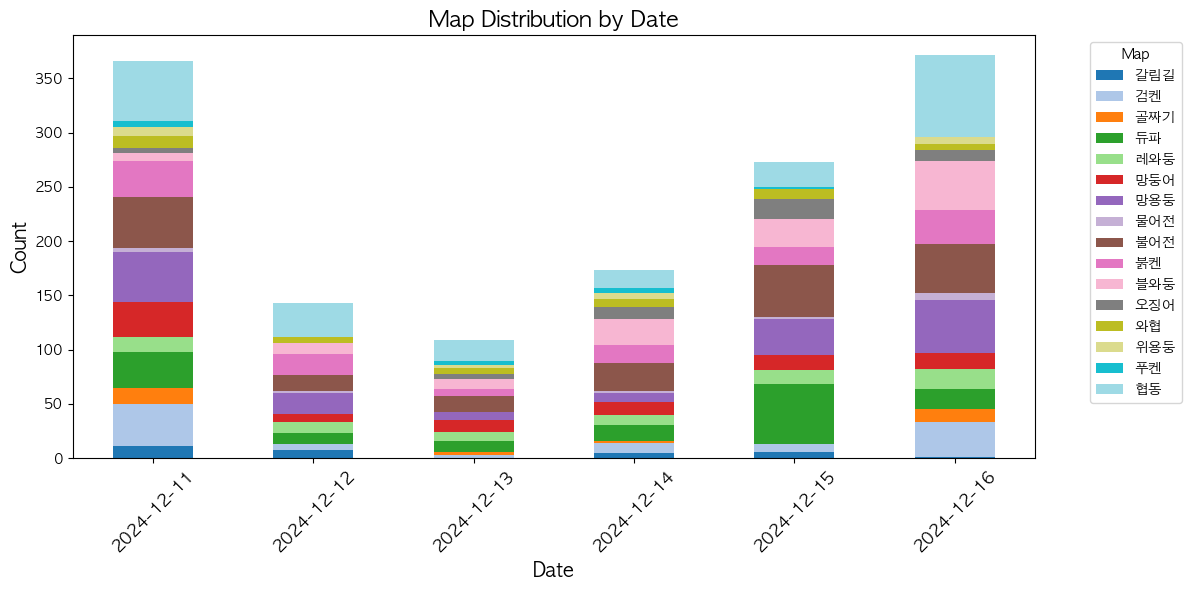

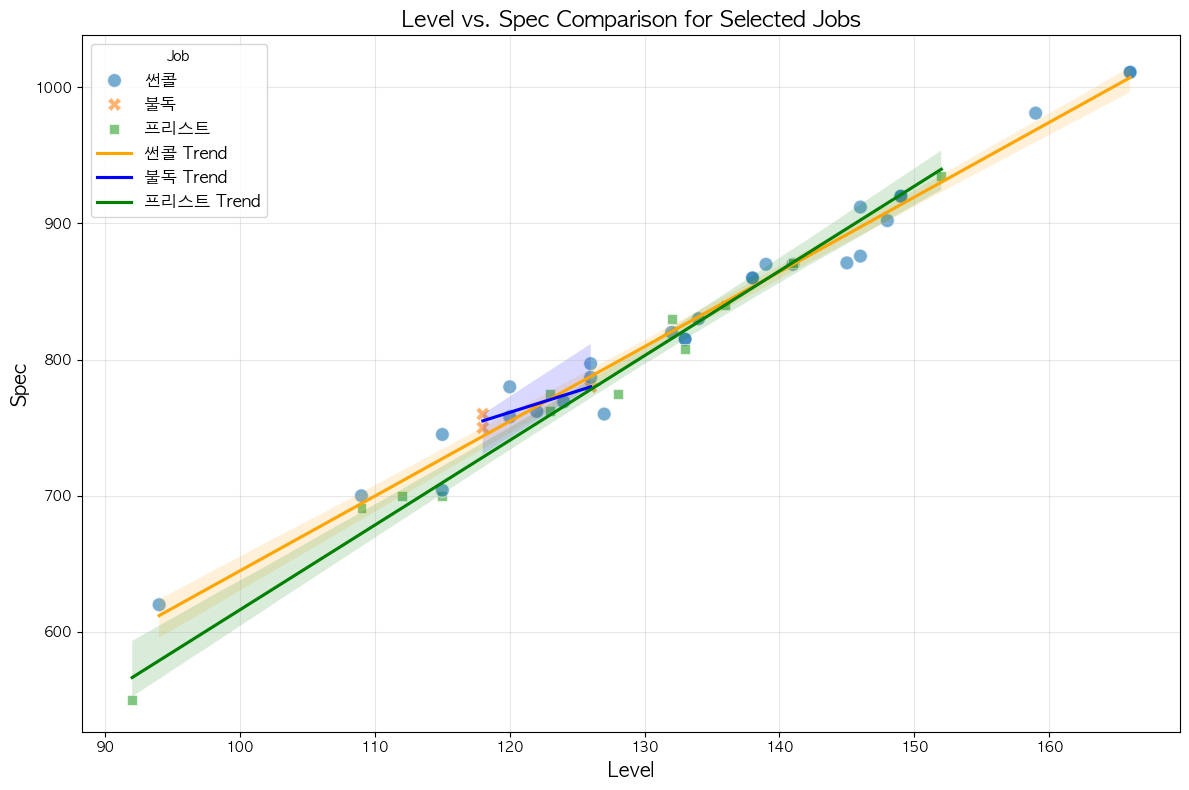

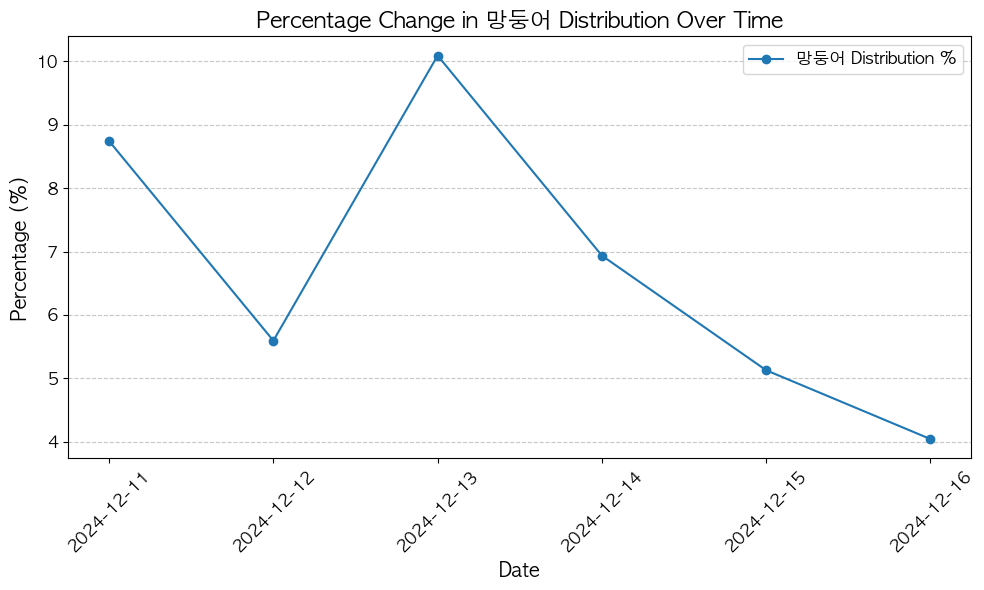

In [824]:
map_dist(df)
job_dist(df)
level_dist(df)
level_dist_by_job(df)
average_spec_by_job(processed_df)
plot_job_frequency_by_map(df)
plot_level_by_map_by_job(df, "허밋")
plot_level_spec_with_regression(processed_df, "허밋")
plot_combined_scatter_with_regression_by_job_level(processed_df, "허밋", 130)
plot_combined_scatter_with_regression_by_level(processed_df, 150)
visualize_spec_validity_by_map(df)
visualize_spec_validity_by_job(df)
visualize_map_distribution_by_date(df)
visualize_level_spec_comparison(processed_df, ['썬콜', '불독', '프리스트'])
visualize_map_percentage_change(df, "망둥어")

In [805]:
# unique_maps = df["map"].unique()
# print("Maps in the data:")
# for map_name in unique_maps:
#     print(map_name)

In [806]:
# Display basic information about the DataFrame
print("Basic Info:")
print(df.info())

print("\nData Overview:")
print(df.head())

# Count frequency of maps
map_counts = df["map"].value_counts()

print("\nMap Frequency:")
print(map_counts)

# Count frequency of jobs
job_counts = df["job"].value_counts()

print("\nJob Frequency:")
print(job_counts)

# Distribution of levels by job
print("\nLevel Statistics by Job:")
print(df.groupby("job")["level"].describe())

# Convert 'level' column to numeric for analysis
df["level"] = pd.to_numeric(df["level"], errors="coerce")

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1738 entries, 0 to 1737
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   party_id           1738 non-null   int64  
 1   time               1738 non-null   object 
 2   level              1716 non-null   float64
 3   job                1738 non-null   object 
 4   spec               229 non-null    float64
 5   map                1435 non-null   object 
 6   date               1738 non-null   object 
 7   valid              1738 non-null   bool   
 8   valid_spec         1738 non-null   bool   
 9   spec_by_level      229 non-null    float64
 10  avg_spec_by_level  1585 non-null   float64
dtypes: bool(2), float64(4), int64(1), object(4)
memory usage: 125.7+ KB
None

Data Overview:
   party_id     time  level    job  spec  map        date  valid  valid_spec  \
0         1  오후 1:11   96.0     허밋   NaN  NaN  2024-12-11  False       False   
1  

In [807]:
# 1. Map Distribution
def map_dist(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(y="map", data=df, order=map_counts.index, palette="viridis")
    plt.title("Frequency of Maps")
    plt.xlabel("Count")
    plt.ylabel("Map")
    plt.tight_layout()
    plt.show()

# 2. Job Distribution
def job_dist(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(y="job", data=df, order=job_counts.index, palette="coolwarm")
    plt.title("Frequency of Jobs")
    plt.xlabel("Count")
    plt.ylabel("Job")
    plt.tight_layout()
    plt.show()

# 3. Level Distribution Overall
def level_dist(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df["level"], kde=True, bins=30, color="skyblue")
    plt.title("Level Distribution")
    plt.xlabel("Level")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 4. Level Distribution by Job
def level_dist_by_job(df):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=df["job"], y=df["level"], data=df, palette="muted")
    plt.title("Level Distribution by Job")
    plt.xlabel("Job")
    plt.ylabel("Level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [808]:
def average_spec_by_job(df):
    # Ensure the 'spec' column is numeric, replacing non-numeric values with NaN
    df['spec'] = pd.to_numeric(df['spec'], errors='coerce')
    
    # Calculate the average spec by job, ignoring NaN values
    average_spec_by_job = df.groupby('job')['spec'].mean().reset_index()
    
    # Fill NaN values with 0 for jobs with no spec data
    average_spec_by_job['spec'] = average_spec_by_job['spec'].fillna(0)
    
    # Ensure all jobs are represented, even if they have no spec data
    all_jobs = list(job_dict.values())  # Ensure all jobs from job_dict are present
    missing_jobs = [job for job in all_jobs if job not in average_spec_by_job['job'].values]
    
    # Create a DataFrame for missing jobs with spec value set to 0
    missing_jobs_df = pd.DataFrame({'job': missing_jobs, 'spec': [0]*len(missing_jobs)})
    
    # Concatenate the missing jobs DataFrame with the existing DataFrame
    average_spec_by_job = pd.concat([average_spec_by_job, missing_jobs_df], ignore_index=True)
    
    # Sort the data for better visualization
    average_spec_by_job = average_spec_by_job.sort_values('spec', ascending=False)
    
    # Set up the visualizations
    plt.figure(figsize=(10, 6))
    sns.barplot(x='spec', y='job', data=average_spec_by_job, palette='viridis')
    
    # Add labels and title
    plt.xlabel('Average Spec')
    plt.ylabel('Job')
    plt.title('Average Spec by Job')
    
    # Display the plot
    plt.show()

In [809]:
def plot_job_frequency_by_map(df):
    # Count the number of occurrences of each job in each map
    job_map_counts = df.groupby(["map", "job"]).size().reset_index(name="count")
    
    # Create a pivot table for better visualization
    job_map_pivot = job_map_counts.pivot(index="map", columns="job", values="count").fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(job_map_pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Job Count'})
    plt.title("Job Frequency by Map")
    plt.ylabel("Map")
    plt.xlabel("Job")
    plt.show()

In [810]:
import numpy as np
from sklearn.linear_model import LinearRegression

def plot_level_spec_with_regression(df, input_job):
    """
    Plots Level vs Spec for a specific job with a linear regression line and equation.

    Parameters:
    - df: DataFrame containing the data.
    - input_job: The specific job to filter and plot (e.g., '허밋').
    """
    job_df = df[df["job"] == input_job].dropna(subset=["level", "spec"])
    
    # Check if there are enough data points for regression
    if len(job_df) < 2:
        print(f"Not enough data points to compute regression for job: {input_job}")
        return

    # Prepare data for linear regression
    X = job_df["level"].values.reshape(-1, 1)
    y = job_df["spec"].values
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    coef = model.coef_[0]
    intercept = model.intercept_
    
    # Regression equation
    equation = f"Spec = {coef:.2f} * Level + {intercept:.2f}"
    
    # Plot Level vs Spec
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=job_df, x="level", y="spec", s=100, label=f"{input_job} Data")
    sns.lineplot(x=job_df["level"], y=model.predict(X), color="red", label="Regression Line")
    plt.title(f"{input_job}'s Level vs Spec", fontsize=16)
    plt.suptitle(equation, fontsize=12, color="gray")
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [811]:
def plot_level_by_map_by_job(df, job):
    job_df = df[df["job"] == job]
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=job_df, x="map", y="level", palette="Set2")
    plt.title(f"{job} 레벨별 맵")
    plt.xlabel("Map")
    plt.ylabel("Level")
    plt.xticks(rotation=45)
    plt.show()

In [812]:
def visualize_spec_validity_by_map(df):
    """
    Visualizes the validity of the data by map using stacked bars.
    """
    # Count valid and invalid entries for each map
    spec_validity_by_map = df.groupby(['map', 'valid_spec']).size().unstack(fill_value=0)

    # Reset index for plotting
    spec_validity_by_map = spec_validity_by_map.reset_index()

    # Set up figure
    plt.figure(figsize=(12, 7))

    # Plot stacked bars
    plt.bar(spec_validity_by_map['map'], spec_validity_by_map[0], label='미기재', color='#FF6F61')
    plt.bar(spec_validity_by_map['map'], spec_validity_by_map[1], bottom=spec_validity_by_map[0], label='기재', color='#6B8E23')

    # Customize plot
    plt.title('맵별 스공기재여부', fontsize=16)
    plt.xlabel('Map', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='Spec Validity', fontsize=12)
    plt.tight_layout()
    plt.show()


def visualize_spec_validity_by_job(df):
    """
    Visualizes the validity of the data by job using stacked bars.
    """
    # Count valid and invalid entries for each job
    validity_by_job = df.groupby(['job', 'valid_spec']).size().unstack(fill_value=0)

    # Reset index for plotting
    validity_by_job = validity_by_job.reset_index()

    # Set up figure
    plt.figure(figsize=(12, 7))

    # Plot stacked bars
    plt.bar(validity_by_job['job'], validity_by_job[0], label='미기재', color='#FF6F61')
    plt.bar(validity_by_job['job'], validity_by_job[1], bottom=validity_by_job[0], label='기재', color='#6B8E23')

    # Customize plot
    plt.title('직업별 스공기재여부', fontsize=16)
    plt.xlabel('Job', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='스공기재여부', fontsize=12)
    plt.tight_layout()
    plt.show()

In [813]:
def visualize_map_distribution_by_date(df):
    """
    Visualizes map distribution by date as a stacked bar chart with diverse colors.
    """
    # Count occurrences of maps by date
    map_counts = df.groupby(['date', 'map']).size().unstack(fill_value=0)

    # Generate a colormap with as many distinct colors as maps
    num_maps = map_counts.shape[1]
    colormap = cm.get_cmap('tab20', num_maps)  # Use 'tab20' or any other diverse colormap
    colors = [mcolors.to_hex(colormap(i)) for i in range(num_maps)]

    # Plot stacked bar chart
    map_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)
    plt.title('Map Distribution by Date', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='Map', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [825]:
def plot_combined_scatter_with_regression_by_level(df, level_threshold):
    """
    Filters data by level threshold and plots a scatterplot for map, level, and spec
    with regression lines per job and map as the marker style.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        level_threshold (int): The minimum level to filter by.
    """
    # Filter the DataFrame
    filtered_df = df[df["level"] >= level_threshold]

    if filtered_df.empty:
        print(f"No data found with level >= {level_threshold}")
        return

    # Ensure level and spec are numeric
    filtered_df["level"] = pd.to_numeric(filtered_df["level"], errors="coerce")
    filtered_df["spec"] = pd.to_numeric(filtered_df["spec"], errors="coerce")

    # Drop rows with missing or invalid level/spec values
    filtered_df = filtered_df.dropna(subset=["level", "spec"])

    # Plot scatterplot
    plt.figure(figsize=(14, 10))
    scatter = sns.scatterplot(
        data=filtered_df,
        x="level",
        y="spec",
        hue="job",
        style="map",  # Different marker styles for maps
        palette="husl",
        s=100,
        alpha=0.6,
        edgecolor="w"
    )

    # Add regression lines for each job
    from sklearn.linear_model import LinearRegression
    import numpy as np

    unique_jobs = filtered_df["job"].unique()
    for job in unique_jobs:
        job_data = filtered_df[filtered_df["job"] == job]
        x = job_data["level"].values.reshape(-1, 1)
        y = job_data["spec"].values

        if len(x) > 1:  # Ensure sufficient data points for regression
            model = LinearRegression()
            model.fit(x, y)
            coef = model.coef_[0]
            intercept = model.intercept_
            sns.lineplot(
                x=x.flatten(),
                y=model.predict(x),
                label=f"{job} Trend (y={coef:.2f}x+{intercept:.2f})",
                color=scatter.legend_.get_texts()[list(unique_jobs).index(job)].get_color(),
                linewidth=2
            )

    # Customize plot appearance
    plt.title(f"Combined Scatter and Regression (Level >= {level_threshold})", fontsize=16)
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.legend(title="Job and Map", fontsize=12, loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Display the plot
    plt.show()


In [815]:
def plot_combined_scatter_with_regression(df, level_threshold):
    """
    Filters data by level threshold and plots a scatterplot for map, level, and spec
    with regression lines per job and map as the marker style.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        level_threshold (int): The minimum level to filter by.
    """
    # Filter the DataFrame
    filtered_df = df[df["level"] >= level_threshold]

    if filtered_df.empty:
        print(f"No data found with level >= {level_threshold}")
        return

    # Ensure level and spec are numeric
    filtered_df["level"] = pd.to_numeric(filtered_df["level"], errors="coerce")
    filtered_df["spec"] = pd.to_numeric(filtered_df["spec"], errors="coerce")

    # Drop rows with missing or invalid level/spec values
    filtered_df = filtered_df.dropna(subset=["level", "spec"])

    # Plot scatterplot
    plt.figure(figsize=(14, 10))
    scatter = sns.scatterplot(
        data=filtered_df,
        x="level",
        y="spec",
        hue="job",
        style="map",  # Different marker styles for maps
        palette="husl",
        s=100,
        alpha=0.6,
        edgecolor="w"
    )

    # Add regression lines for each job
    from sklearn.linear_model import LinearRegression
    import numpy as np

    unique_jobs = filtered_df["job"].unique()
    for job in unique_jobs:
        job_data = filtered_df[filtered_df["job"] == job]
        x = job_data["level"].values.reshape(-1, 1)
        y = job_data["spec"].values

        if len(x) > 1:  # Ensure sufficient data points for regression
            model = LinearRegression()
            model.fit(x, y)
            coef = model.coef_[0]
            intercept = model.intercept_
            sns.lineplot(
                x=x.flatten(),
                y=model.predict(x),
                label=f"{job} Trend (y={coef:.2f}x+{intercept:.2f})",
                color=scatter.legend_.get_texts()[list(unique_jobs).index(job)].get_color(),
                linewidth=2
            )

    # Customize plot appearance
    plt.title(f"Combined Scatter and Regression (Level >= {level_threshold})", fontsize=16)
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.legend(title="Job and Map", fontsize=12, loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Display the plot
    plt.show()


In [816]:
def visualize_map_percentage_change(df, map_name):
    """
    Visualizes the percentage change of a specific map's distribution over time.
    
    Parameters:
    - df: DataFrame containing the data.
    - map_name: The name of the map to analyze.
    """
    # Count occurrences of maps by date
    map_counts = df.groupby(['date', 'map']).size().unstack(fill_value=0)

    # Calculate the percentage contribution of each map per date
    map_percentage = map_counts.div(map_counts.sum(axis=1), axis=0) * 100

    # Extract the percentage values for the specific map
    if map_name not in map_percentage.columns:
        print(f"Map '{map_name}' not found in the data.")
        return
    
    map_data = map_percentage[map_name]

    # Plot the percentage change over time
    plt.figure(figsize=(10, 6))
    map_data.plot(kind='line', marker='o', label=f"{map_name} Distribution %")
    plt.title(f"Percentage Change in {map_name} Distribution Over Time", fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

In [817]:
def spec(lv):
    return 22.65*lv-553
spec(131)

2414.1499999999996

In [818]:
def calculate_avg_spec_for_job_and_level(df, input_job, input_level):
    filtered_df = df[
        (df["job"] == input_job) &
        (df["level"] >= input_level - 5) &
        (df["level"] <= input_level + 5)
    ]
    
    # Check if any rows match the criteria
    if filtered_df.empty:
        print(f"No data found for job '{input_job}' and level range {input_level-5} to {input_level+5}.")
        return None

    # Calculate and return the average spec
    average_spec = filtered_df["spec"].mean()
    print(f"Average spec for job '{input_job}' and level range {input_level-5} to {input_level+5}: {average_spec:.2f}")
    return average_spec

avg_spec = calculate_avg_spec_for_job_and_level(df_processed, "허밋", 131)

Average spec for job '허밋' and level range 126 to 136: 2398.50


In [819]:
def print_high_level_data(df, threshold=160):
    high_level_data = df[df["level"] >= threshold]
    if high_level_data.empty:
        print(f"No data found where level is {threshold} or higher.")
    else:
        print(f"Data where level is {threshold} or higher:")
        print(high_level_data)

# Example usage
print_high_level_data(df_combined_valid_processed, threshold=160)

Data where level is 160 or higher:
    party_id      time level    job  spec  map        date valid  valid_spec  \
6         24   오후 1:13   164     허밋  3200   협동  2024-12-11  True        True   
12        75   오후 1:16   162  크루세이더  5500  망둥어  2024-12-11  True        True   
19       169   오후 1:34   164     허밋  3250   협동  2024-12-11  True        True   
20       181   오후 1:35   166     썬콜  1011  망용둥  2024-12-11  True        True   
93        99   오후 2:53   161    용기사  5900  블와둥  2024-12-14  True        True   
103        8   오후 3:47   166     썬콜  1011  망용둥  2024-12-15  True        True   
150      142  오전 12:43   160     허밋  3250   협동  2024-12-16  True        True   
154      151  오전 12:44   169     허밋  3300   협동  2024-12-16  True        True   

     spec_by_level  avg_spec_by_level  
6        19.512195          18.677387  
12       33.950617          32.361493  
19       19.817073          18.677387  
20        6.090361           6.213098  
93       36.645963          36.081929  
103 

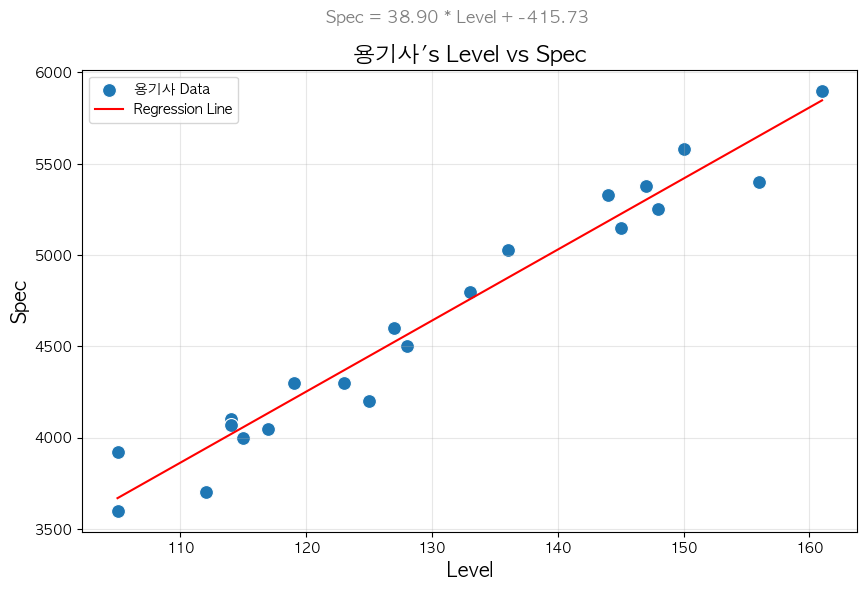

In [820]:
plot_level_spec_with_regression(processed_df, "용기사")

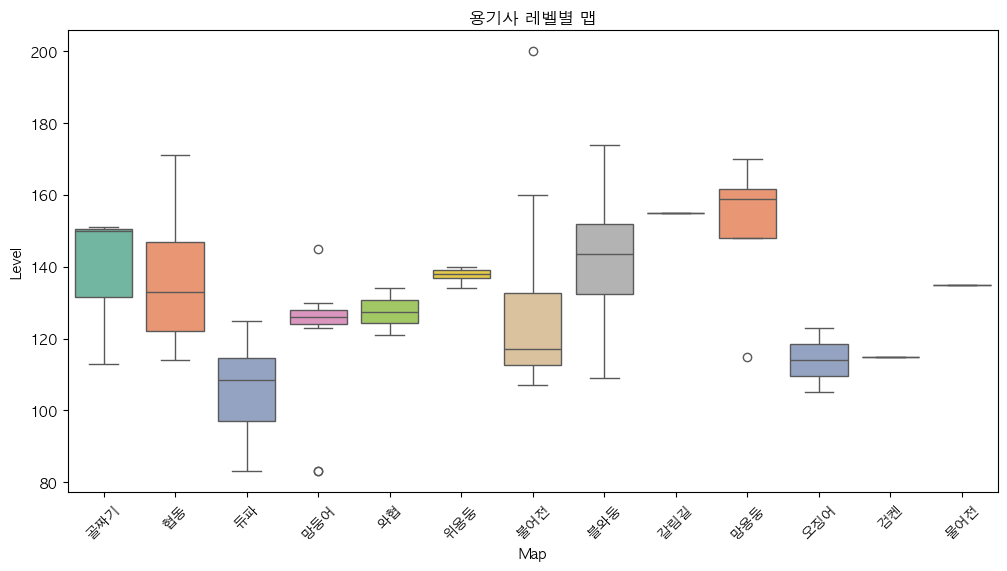

In [821]:
plot_level_by_map_by_job(df, "용기사")

In [822]:
#by Willkie